In [1]:
import random
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
from numba import jit
pd.set_option('display.max_columns', 50)
from copy import deepcopy
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor


class MonkeyBot(object):
    def __init__(self, dfEnv, cash=1000, share=0, pv=0, now_yes_share=0):
        self.cash = cash
        self.share = share
        self.pv = pv
        self.asset_history_list = []
        self.action_list = []
        
        self.env = deepcopy(dfEnv)

    def buy(self, stock_price, cost, fold=1):
        if self.cash < stock_price:
            self.hold(stock_price)
            
        else:
            num_affordable = int(self.cash // stock_price)
            buy_amount = int(num_affordable // fold)
            self.cash = self.cash - stock_price * buy_amount
            self.share = self.share + buy_amount
            self.pv = stock_price * self.share

             # Adding transaction cost
            self.trading_cost(buy_amount, cost)
            
        # Append action to action list
        self.action_list.append('Buy')

    def sell(self, stock_price, cost, fold=1):
        if self.share == 0:
            self.hold(stock_price)
            
        else:
            sell_amount = int(self.share // fold)
            self.cash = self.cash + stock_price * sell_amount
            self.pv = 0
            self.share = 0

            # Adding transaction cost
            self.trading_cost(sell_amount, cost)
            
        self.action_list.append('Sell')

    def hold(self, stock_price):
        self.pv = stock_price * self.share
#         self.action_list.append('Hold')

    def trading_cost(self, trading_amount, cost):
            if cost is None:
                pass                
            elif cost == 'low':
                if trading_amount * 0.01 < 1.99:
                    self.cash = self.cash - 1.99
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'medium':
                if trading_amount * 0.01 < 5:
                    self.cash = self.cash - 5
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'high':
                if trading_amount * 0.01 < 7:
                    self.cash = self.cash - 7
                else:
                    self.cash = self.cash - trading_amount * 0.01
            else:
                raise ValueError("Wrong cost parameter!")
        
    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def yes_share(self):
        # Represent chimp asset in state_action
        if self.share > 0:
            return 1
        else:
            return 0

    def make_decision(self, x, cost):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x, cost)
        else:
            self.sell(x, cost)

        return self.pv # for frame-wise operation

    def simulate(self, iters, cost=None):
        start_time = time.time()
        for i in range(iters):
            for index, row in self.env.iterrows():
                self.make_decision(row['Trade Price'], cost)
            self.asset_history_list.append(self.pv + self.cash)
            self.reset()
        print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))
        
        return self.asset_history_list, self.action_list

class macdChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    valid_actions = ['Buy', 'Sell']

    num_trial = 500
    trial_counter = 0 # For getting the trial number

    trial_meta_info = {} # For monitoring what happens in each trial

    epsilon = 1
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

#     track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
#     track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

#     track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, iter_random_rounds, gamma, test_mode=False, cash=1000, share=0, pv=0, random_state=0):
        super(macdChimpBot, self).__init__(dfEnv, iter_random_rounds, cash, share, pv)
        
        self.random_state = random_state
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)
        self.gamma = gamma
        self.test_mode = test_mode
        self.num_features = len(dfEnv.columns) - 1
        self.random_rounds = iter_random_rounds # Number of rounds where the bot chooses to go monkey
        
        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        # self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

#         self.negative_reward = 0
#         self.n_reward_hisotry = []
#         self.net_reward = 0

        self.reset_counter = 0

        # Smartcab use only
        # self.penalty = False
        # self.num_step = 0 # Number of steps for each trial; get reset each time a new trial begins

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col' + str(x) for x in range(1, self.num_features + 1 + 1)]
        q_df_column_list.append('Q')
        # q_df_column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Q']
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col' + str(self.num_features + 1)] = self.q_df['col' + str(self.num_features + 1)].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]
        # self.X_train, self.X_test, self.y_train, self.y_test = cross_validation.train_test_split(self.q_df_X, self.q_df_y, test_size=0.1, random_state=0)

    def train_on_q_df(self):
        reg = RandomForestRegressor(n_estimators=128, max_features='sqrt', n_jobs=-1, random_state=self.random_state)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
#         print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    # def yes_share(self):
    #     # Represent chimp asset in state_action
    #     if self.share > 0:
    #         return 1
    #     else:
    #         return 0

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        # now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > self.num_features:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            # # K-Q Algorithm
            # if np.random.choice(2, p = [0.9, 0.1]) == 1 and len(self.q_dict) > 30000:
            # if _[1] == 0 and np.random.choice(2, p = [0.7, 0.3]) == 1 and len(self.q_dict) > 30000:
            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")
                    # start_time = time.time()
                    # self.update_q_model()

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)
                    # print("Q-dreamed: {0} for Act: {1}, taking {2} seconds.".format(self.q_dict[now_row_key], act, time.time() - start_time))

            # print(act, self.q_dict[now_row_key])

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        # prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > self.num_features + 2:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        if prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'Yes'):
            self.track_key1[prev_states_key[-1]] += 1
        elif prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'No'):
            self.track_key2[prev_states_key[-1]] += 1
        # elif prev_states_key[:-1] == ('Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Average', 'High', 'Average', 'Average', 'Average', 'Low', 'Average', 'Very Low', 'Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'Very Low', 'Very Low', 'Average', 'Very Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Average', 'No'):
        #     self.track_key2[prev_states_key[-1]] += 1

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.asset_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.test_mode is True:
            self.epsilon = 0
        
        else:
            if self.epsilon - 1/self.random_rounds > 0.00001: # Epislon threshold: 0.01
                self.random_counter += 1
                self.epsilon = self.epsilon - 1/self.random_rounds
            else:
                self.epsilon = 0.00001 # Epislon threshold: 0.1
                self.policy_counter += 1

        self.reset_counter += 1

        if self.reset_counter % self.random_rounds == 0:
            self.update_q_model()

        if np.abs(self.epsilon - 0.00001) > 0.000001:
            self.action_list = []
        
        # self.num_step = 0 # Recalculate the steps for the new trial
        # self.penalty = False
        # self.fail = False

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self, cost):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > self.num_features + 1:
            print(len(now_states))
            print(self.num_features)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # now_states = list(now_states)
        # print(type(self.now_row))
        now_states.pop() # disregard the Trade Price

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        random.seed(datetime.now())
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        # print("What the FUCK?!")
        if self.decision == 0: # if zero, go random
            random.seed(datetime.now())
            action = random.choice(self.valid_actions)
            # if tuple(now_states) == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High'):
            #     self.track_random_decision[action] += 1
        else: # else go with the policy
            # print("now_states: {}".format(now_states))
            # self.now_yes_share = self.yes_share()
            action = self.make_decision(now_states)

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # print("Now Action Real: {}".format(action))
        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1], cost)
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1], cost)
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        # self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        # if len(self.q_dict) > 20000:
        #     self.update_q_model()

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        # if reward < 0:
        #     self.penalty = True

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0
        # print "ChimpBot.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(action, self.now_row[-1], self.cash, self.share, self.cash + self.pv, self.reward)  # [debug]
        # print('Portfolio + Cash: {}'.format(self.cash + self.pv))
        # print("================================")
    
    def simulate(self, cost=None):
        start_time = time.time()

        for i in range(self.random_rounds):
            for l in range(len(self.env)):
                self.update(cost)
            self.reset()
            print(self.asset_history_list[-1])
            print("Round {} finished".format(i + 1))
            
        print("{0} rounds of simulation with cost = {1}, took {2} seconds".format(self.random_rounds, cost, time.time() - start_time))
        return self.asset_history_list, self.action_list

In [3]:
jpm_full = pd.DataFrame.from_csv('jpm_full.csv')

In [26]:
jpm_full.head()

,0,1,2,3,Trade Price
1983-12-30,-0.300457,-0.029136,0.039326,-0.042845,2.602623
1984-01-03,-0.300328,-0.028349,0.039937,-0.032179,2.602623
1984-01-04,-0.298600,-0.033049,0.052396,-0.038055,2.713529
1984-01-05,-0.296578,-0.036492,0.062512,-0.035051,2.802256
1984-01-06,-0.297007,-0.036466,0.058274,-0.044133,2.772681


In [8]:
god_chimp = macdChimpBot(dfEnv=jpm_full, iter_random_rounds=60000, gamma=0.75)
asset_history_list, action_list = god_chimp.simulate(cost='high')

print(pd.Series(action_list).describe())
print(asset_history_list[-1])

Running the first time...no prevs exist.
No reward yet...0 assigned.
60000 rounds of simulation with cost = high, took 132291.043876 seconds
count     8256
unique       3
top       Hold
freq      4367
dtype: object
3.11803080497e+29


In [9]:
high_cost_action = action_list

In [10]:
import pickle

with open('high_cost_action_60k_0.75.pickle', 'wb') as f:
  pickle.dump(high_cost_action, f, pickle.HIGHEST_PROTOCOL)

In [11]:
god_chimp09 = macdChimpBot(dfEnv=jpm_full, iter_random_rounds=60000, gamma=0.9)
asset_history_list, action_list = god_chimp09.simulate(cost='high')

print(pd.Series(action_list).describe())
print(asset_history_list[-1])

Running the first time...no prevs exist.
No reward yet...0 assigned.
60000 rounds of simulation with cost = high, took 118010.766502 seconds
count     8256
unique       3
top       Hold
freq      4414
dtype: object
2.06544060819e+29


In [4]:
god_chimp = macdChimpBot(dfEnv=jpm_full, iter_random_rounds=50, gamma=0.9)
asset_history_list, action_list = god_chimp.simulate(cost=None)

print(pd.Series(action_list).describe())
print(asset_history_list[-1])

Running the first time...no prevs exist.
No reward yet...0 assigned.
7478.282415
Round 1 finished
5697.299751
Round 2 finished
32221.317783
Round 3 finished
95919.781808
Round 4 finished
253913.798162
Round 5 finished
3447419.24976
Round 6 finished
1916062.76524
Round 7 finished
18693206.459
Round 8 finished


KeyboardInterrupt: 

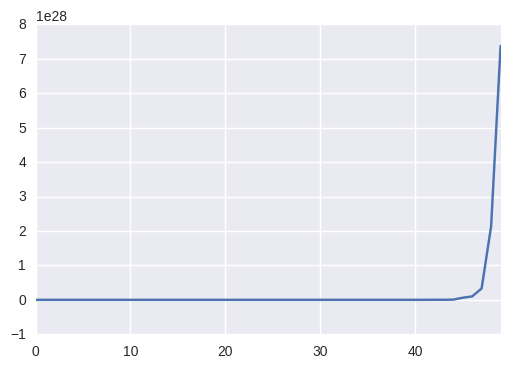

In [37]:
pd.Series(asset_history_list).plot()

/home/calvinjku/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


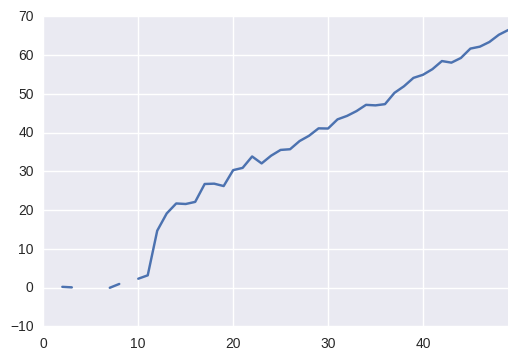

In [38]:
np.log(pd.Series(asset_history_list)).plot()